In [1]:
# Thanks to Camille Rochefort-Boulanger for sharing this code with us!

import numpy as np
import pandas as pd
import torch.utils.data as tdata

In [2]:
# how to change seed.

seed_number = 5
np.random.seed(seed_number) # changes seed for numpy


In [3]:
# Mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
root = '/content/gdrive/My Drive/Covid Project/'

In [5]:
# Load data
data = np.load(root + 'Copy of be_corrected_vaf_0.0.npy')

In [6]:
data = data.T

In [7]:
from sklearn.decomposition import PCA

pca = PCA(n_components=250)
transformed_data = pca.fit_transform(data)

In [8]:
transformed_data.shape

(29678, 250)

In [9]:
data = transformed_data

In [10]:
(data[4] == 0).mean()

0.0

In [11]:
data = (data - data.mean())/data.std()  #try without

Targets



In [80]:
#targets = np.load(root + 'targets_2e-05_0.0.npy')
#targets = np.load(root + 'Copy of targets_0.0001_0.0.npy')
targets = np.load(root + 'targets_0.001_0.0.npy')
#targets = np.load(root + 'targets_0.005_0.0.npy')

In [81]:
targets.shape, data.shape

((29678,), (29678, 250))

In [82]:
class Covid19Dataset(tdata.Dataset):
  def __init__(self, vafs, target):
    super().__init__()
    self.vafs = vafs
    self.targets = targets.astype(np.float32)
    # self.seq_center = ...

  def __getitem__(self, idx):
    return self.vafs[idx], self.targets[idx] # self.seq_center[idx] ...
  def __len__(self):
    return len(self.targets)

In [83]:
mydata = Covid19Dataset(data, targets)

In [84]:
# create validation and test sets #try changing size
from torch.utils.data import random_split

train, valid, test = random_split(mydata, [len(mydata)-10000, 5000, 5000])

In [85]:
train_data_loader = tdata.DataLoader(train, batch_size=64, num_workers=2, shuffle=True)
valid_data_loader = tdata.DataLoader(valid, batch_size=64, num_workers=2, shuffle=False)
test_data_loader = tdata.DataLoader(test, batch_size=64, num_workers=2, shuffle=False)

In [86]:
next(iter(train_data_loader))

[tensor([[-0.1827, -0.1079, -0.1248,  ...,  0.1088,  0.1472, -0.0400],
         [-0.3586, -0.0031, -0.0921,  ...,  0.0178,  0.0355, -0.0131],
         [-0.3837, -0.0449, -0.0888,  ..., -0.0872,  0.0350, -0.0369],
         ...,
         [-0.2129, -0.0216, -0.1185,  ..., -0.0218, -0.0570,  0.0100],
         [-0.2923, -0.1045, -0.0301,  ..., -0.0146, -0.0182,  0.0991],
         [-0.4731,  0.0174, -0.1576,  ...,  0.0145,  0.0021, -0.0054]],
        dtype=torch.float64),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

Neural Network

In [87]:
from torch import nn as nn
from torch import optim

In [88]:
class Model(nn.Module):
  def __init__(self, in_feats, hidden_feats):
    super().__init__()
    self.l1 = nn.Linear(in_feats, hidden_feats)
    #self.act1 = nn.ReLU()
    #self.l2 = nn.Linear(hidden_feats, 1)
    #self.act2 = nn.ReLU()
    self.o = nn.Sigmoid()
  def forward(self, x):
    #x = self.act1(self.l1(x))
    #x = self.act2(self.l2(x))
    x = self.l1(x)
    return self.o(x)

In [89]:
model = Model(250, 1)

In [90]:
class Meter():
  def __init__(self):
    self.n = 0
    self.acc = 0
  
  def update(self, model_output, labels):
    self.n += model_output.shape[0]
    self.acc += ((out > 0.5) == labels).sum() 

  def compute_accuracy(self):
    return self.acc / self.n
  
  def reset_meter(self):
    self.n = 0
    self.acc = 0
  
  # Implement precision and recall here!

meter = Meter()

In [101]:
# initialize things needed for training!
# see docs for more details: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), weight_decay=0.01)  # alternative to SGD but easier to use! May want to use weight decay.

Weighted loss

In [102]:
import torch
critereon = nn.BCELoss(reduction='none') # only difference from nn.CrossEntropyLoss is that this is binary (doesnt include sigmoid)

In [103]:
_ = torch.manual_seed(seed_number) # change seed for PyTorch

In [104]:
weight=torch.tensor([targets.mean(), 1/targets.mean()], dtype=torch.float32)

In [105]:
losses = []
accs = []
valid_accs = []

for e in range(25):
  meter.reset_meter()
  model.train()
  for i, (inp, tgt) in enumerate(train_data_loader):
    out = model(inp.float()).squeeze()
    meter.update(out, tgt)

    # make weights
    weight = [100,1]
    loss = critereon(out, tgt)
    batch_weights = torch.zeros_like(tgt)
    batch_weights[tgt == 0] = weight[0]
    batch_weights[tgt == 1] = weight[1]
    loss = loss.mean()

    loss.backward()
    optimizer.step()
    losses.append(loss.detach())
    #if i % 50 == 0:
  accs.append(100*meter.compute_accuracy())
  print('{} [{}/{}] loss: {:.2f} Acc: {:.2f}%'.format(e, i, len(train_data_loader), loss.item(), 100*meter.compute_accuracy()))

  meter.reset_meter()
  model.eval()
  for i, (inp, tgt) in enumerate(valid_data_loader):

    out = model(inp.float()).squeeze()
    meter.update(out.squeeze(), tgt)

  valid_accs.append(100*meter.compute_accuracy())
  print('{} [{}/{}] Valid Acc: {:.2f}%'.format(e, i, len(valid_data_loader), 100*meter.compute_accuracy()))

0 [307/308] loss: 0.01 Acc: 94.73%
0 [78/79] Valid Acc: 94.72%
1 [307/308] loss: 0.49 Acc: 95.25%
1 [78/79] Valid Acc: 95.04%
2 [307/308] loss: 0.20 Acc: 94.80%
2 [78/79] Valid Acc: 93.36%
3 [307/308] loss: 0.68 Acc: 92.68%
3 [78/79] Valid Acc: 93.46%
4 [307/308] loss: 0.00 Acc: 94.74%
4 [78/79] Valid Acc: 94.82%
5 [307/308] loss: 0.49 Acc: 94.51%
5 [78/79] Valid Acc: 93.62%
6 [307/308] loss: 3.76 Acc: 93.58%
6 [78/79] Valid Acc: 94.74%
7 [307/308] loss: 0.47 Acc: 94.90%
7 [78/79] Valid Acc: 94.34%
8 [307/308] loss: 1.29 Acc: 94.08%
8 [78/79] Valid Acc: 94.90%
9 [307/308] loss: 3.70 Acc: 94.59%
9 [78/79] Valid Acc: 94.34%
10 [307/308] loss: 1.79 Acc: 94.67%
10 [78/79] Valid Acc: 94.66%
11 [307/308] loss: 2.28 Acc: 94.48%
11 [78/79] Valid Acc: 94.96%
12 [307/308] loss: 1.99 Acc: 94.78%
12 [78/79] Valid Acc: 94.68%
13 [307/308] loss: 0.83 Acc: 94.81%
13 [78/79] Valid Acc: 94.72%
14 [307/308] loss: 0.01 Acc: 95.10%
14 [78/79] Valid Acc: 94.68%
15 [307/308] loss: 3.39 Acc: 94.93%
15 [78/79

In [106]:
meter.reset_meter()
model.eval()
test_preds = []
true_labels = []
for i, (inp, tgt) in enumerate(test_data_loader):

  out = model(inp.float()).squeeze()
  test_preds.extend((out > 0.5))
  true_labels.extend(tgt.tolist())
  meter.update(out.squeeze(), tgt)

valid_accs.append(100*meter.compute_accuracy())
print('[{}/{}] Valid Acc: {:.2f}%'.format(i, len(valid_data_loader), 100*meter.compute_accuracy()))

[78/79] Valid Acc: 95.10%


In [107]:
# compute precision/recall of test data!
# for AUC try this out: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

test_preds = np.array(test_preds)
true_labels = np.array(true_labels)

#print(test_preds)
#print(true_labels)
#print(test_preds == true_labels)
print((test_preds == true_labels).sum())
print((test_preds == true_labels).mean())
print(test_preds.sum())
print(true_labels.sum())
#print(true_labels.astype('bool'))
#print(True & True)
#print((test_preds & true_labels.astype('bool')))
print((test_preds & true_labels.astype('bool')).sum())
# precision =  (+ve and predicted +ve) / (predicted +ve)
# recall = (+ve and predicted +ve) / (+ve)

4755
0.951
49
196.0
0


In [108]:
print((test_preds == true_labels).mean()) # accuracy
print((test_preds & true_labels.astype('bool')).sum() / test_preds.sum())  # precision
print((test_preds & true_labels.astype('bool')).sum() / true_labels.sum())  # recall
#seed 2 thresh 1

0.951
0.0
0.0


Diagnostics and curves

ROC here

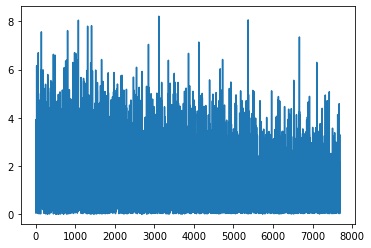

In [109]:
import matplotlib.pyplot as plt

plt.plot(losses)

ROC AUC=0.495


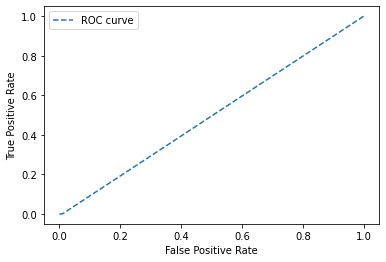

In [110]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve
from matplotlib import pyplot

true_labels_bin = true_labels > 0.5
test_preds_bin = test_preds > 0.5

auc = roc_auc_score(true_labels_bin, test_preds)
print('ROC AUC=%.3f' % (auc))

#tpr = print((test_preds & true_labels.astype('bool')).sum() / true_labels.sum())
#fpr = print((test_preds.sum()-(test_preds & true_labels.astype('bool')).sum()) / (5000 - true_labels.sum()))
fpr, tpr, threshold = roc_curve(true_labels_bin,test_preds)

#plt.plot(fpr, tpr, linestyle='--', label='classifier performance')
plt.plot(fpr, tpr, linestyle='--', label='ROC curve')


# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()
#seed 1 thresh 1

In [72]:
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn import metrics

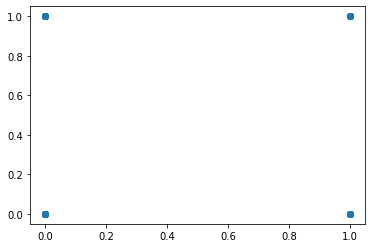

In [59]:
plt.scatter(true_labels, test_preds)

In [36]:
stats.spearmanr(true_labels, test_preds)

SpearmanrResult(correlation=0.003195749903006717, pvalue=0.8212654157909969)

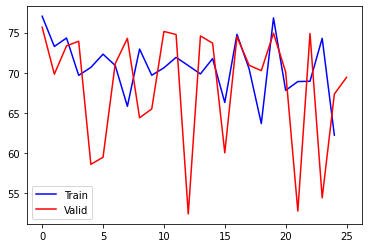

In [37]:
plt.plot(accs, color='blue', label='Train')
plt.plot(valid_accs, color='red', label='Valid')
plt.legend()

In [60]:
#from sklearn.metrics import roc_auc_score, roc_curve, auc, plot_roc_curve
#fpr, tpr, thresh = roc_curve(true_labels,test_preds)
#auc_data = auc(fpr,tpr)

#plt.figure(figsize=(5,5),dpi=100)
#plt.plot(fpr, tpr, linestyle="-")
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")

#plt.legend()

#plt.show()
